In [21]:
import pandas as pd
import epiweeks

In [22]:
import model_utils as mu

In [92]:
mu.DEATH_RATE = 0.36
mu.ICU_RATE = 0.78
mu.HOSPITAL_RATE = 2.18
mu.SYMPTOM_RATE = 10.2
mu.INFECT_2_HOSPITAL_TIME = 11
mu.HOSPITAL_2_ICU_TIME = 4
mu.ICU_2_DEATH_TIME = 4
mu.ICU_2_RECOVER_TIME = 7
mu.NOT_ICU_DISCHARGE_TIME = 5

In [4]:
fips = pd.read_csv('../../../github/covid19-forecast-hub/data-locations/locations.csv')

In [5]:
forecast_date = '2021-01-25'
target_metric = 'death'
target_aggr = 'inc'

In [6]:
metric_map ={'death': 'predicted_death'}

In [7]:
def get_epiweek_enddate(x):
    return epiweeks.Week.fromdate(pd.to_datetime(x).date()).enddate()

In [15]:
def get_target_str(target_end_date, forecast_date, target_metric, target_aggr):
    forecast_date_week_end = get_epiweek_enddate(forecast_date)
    target = '{week} wk ahead {target_aggr} {target_metric}'\
        .format(week=(target_end_date - forecast_date_week_end).days//7 + 1,
                target_aggr=target_aggr,
                target_metric=target_metric)
    return target

In [16]:
def format_forecast(input_forecast, 
                    location_name, 
                    forecast_date,
                    target_metric,
                    target_aggr):
    forecast_date = pd.to_datetime(forecast_date).date()
    input_forecast['target_end_date'] = input_forecast.date.apply(get_epiweek_enddate)
    input_forecast['target'] = input_forecast.target_end_date.apply(get_target_str, args=(forecast_date,
                                                                                          target_metric,
                                                                                          target_aggr))
    input_forecast['forecast_date'] = forecast_date
    input_forecast['location'] = fips.query('location_name == @location_name').location.iloc[0]
    input_forecast['quantile'] = 'NA'
    input_forecast['type'] = 'point'
    input_forecast.rename(columns={metric_map[target_metric]: 'value'}, inplace=True)
    input_forecast['lower_bound_50'] = input_forecast.value - \
                                       (input_forecast.value - input_forecast.lower_bound)**(0.67449/1.95996)
    input_forecast['upper_bound_50'] = input_forecast.value + \
                                       (input_forecast.upper_bound - input_forecast.value)**(0.67449 / 1.95996)
    output = input_forecast[['forecast_date', 'target', 'target_end_date', 'quantile', 'type', 'value', 'location']]

    output_lb = input_forecast[['forecast_date', 'target', 'target_end_date', 'lower_bound', 'location']]
    output_lb.rename(columns={'lower_bound': 'value'}, inplace=True)
    output_lb['quantile'] = 0.025
    output_lb['type'] = 'quantile'
    output_ub = input_forecast[['forecast_date', 'target', 'target_end_date', 'upper_bound', 'location']]
    output_ub.rename(columns={'upper_bound': 'value'}, inplace=True)
    output_ub['quantile'] = 0.975
    output_ub['type'] = 'quantile'

    output_lb_50 = input_forecast[['forecast_date', 'target', 'target_end_date', 'lower_bound_50', 'location']]
    output_lb_50.rename(columns={'lower_bound_50': 'value'}, inplace=True)
    output_lb_50['quantile'] = 0.25
    output_lb_50['type'] = 'quantile'
    output_ub_50 = input_forecast[['forecast_date', 'target', 'target_end_date', 'upper_bound_50', 'location']]
    output_ub_50.rename(columns={'upper_bound_50': 'value'}, inplace=True)
    output_ub_50['quantile'] = 0.75
    output_ub_50['type'] = 'quantile'
    output = pd.concat([output, output_lb, output_ub, output_lb_50, output_ub_50])
    return output.groupby(['forecast_date', 'target', 'target_end_date', 'quantile', 'type', 'location']).sum()\
        .reset_index().query('target_end_date>forecast_date')

In [10]:
def generate_formatted_forecast(scope,
                                location_name,
                                forecast_date,
                                target_metric = 'death',
                                target_aggr = 'inc'):
    forecast_date = pd.to_datetime(forecast_date).date()
    if scope == 'World':
        forecast_fun = mu.get_metrics_by_country
        policy_date_fun = mu.get_policy_change_dates_by_country
    else:
        forecast_fun = mu.get_metrics_by_state_US
        policy_date_fun = mu.get_policy_change_dates_by_state_US
    input_forecast, _, _ = forecast_fun(location_name, 
                                        forecast_horizon=60,
                                        policy_change_dates=policy_date_fun(location_name),
                                        back_test=True, last_data_date=forecast_date)
    input_forecast.index.rename('date', inplace=True)
    input_forecast.reset_index(inplace=True)
    return format_forecast(input_forecast, location_name, forecast_date, target_metric, target_aggr)

In [11]:
def add_cum_forecast(inc_forecast, last_epi_week_cum):
    cum_forecast = inc_forecast.copy()
    cum_forecast['value'] = cum_forecast.groupby('quantile').value.cumsum()+last_epi_week_cum
    cum_forecast['target'] = cum_forecast.target.str.replace('inc', 'cum')
    return pd.concat([inc_forecast, cum_forecast])

In [17]:
US_forecast = generate_formatted_forecast('World', 'US', forecast_date)

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [18]:
US_forecast = US_forecast.query('target!="9 wk ahead inc death"')

In [19]:
forecast_date = pd.to_datetime(forecast_date).date()

In [20]:
last_epiweek_enddate = get_epiweek_enddate(forecast_date+epiweeks.timedelta(-7))

In [21]:
latest_cum_US = mu.get_data_by_country('US').loc[last_epiweek_enddate][0]

In [22]:
latest_cum_US

417439.0

In [23]:
US_forecast

,forecast_date,target,target_end_date,quantile,type,location,value
250,2021-01-25,1 wk ahead inc death,2021-01-30,0.025,quantile,US,17782.285476
251,2021-01-25,1 wk ahead inc death,2021-01-30,0.25,quantile,US,21644.280855
252,2021-01-25,1 wk ahead inc death,2021-01-30,0.75,quantile,US,21772.210946
253,2021-01-25,1 wk ahead inc death,2021-01-30,0.975,quantile,US,26499.936373
254,2021-01-25,1 wk ahead inc death,2021-01-30,NA,point,US,21706.049101
255,2021-01-25,2 wk ahead inc death,2021-02-06,0.025,quantile,US,17554.788282
256,2021-01-25,2 wk ahead inc death,2021-02-06,0.25,quantile,US,22369.926645
257,2021-01-25,2 wk ahead inc death,2021-02-06,0.75,quantile,US,22509.000456
258,2021-01-25,2 wk ahead inc death,2021-02-06,0.975,quantile,US,28680.991643
259,2021-01-25,2 wk ahead inc death,2021-02-06,NA,point,US,22436.526381


In [51]:
US_forecast = add_cum_forecast(US_forecast, latest_cum_US)

In [52]:
US_forecast

,forecast_date,target,target_end_date,quantile,type,location,value
144,2021-01-11,1 wk ahead inc death,2021-01-16,0.025,quantile,US,14091.625414
145,2021-01-11,1 wk ahead inc death,2021-01-16,0.975,quantile,US,24854.201962
146,2021-01-11,1 wk ahead inc death,2021-01-16,NA,point,US,18708.385326
147,2021-01-11,2 wk ahead inc death,2021-01-23,0.025,quantile,US,12809.320049
148,2021-01-11,2 wk ahead inc death,2021-01-23,0.975,quantile,US,27210.546748
149,2021-01-11,2 wk ahead inc death,2021-01-23,NA,point,US,18662.546366
150,2021-01-11,3 wk ahead inc death,2021-01-30,0.025,quantile,US,11602.700085
151,2021-01-11,3 wk ahead inc death,2021-01-30,0.975,quantile,US,29894.361233
152,2021-01-11,3 wk ahead inc death,2021-01-30,NA,point,US,18616.819720
153,2021-01-11,4 wk ahead inc death,2021-02-06,0.025,quantile,US,10491.668454


In [53]:
US_state_list = mu.get_data(scope='US', type='deaths').State.unique()

In [54]:
for state in US_state_list:
    try:
        print(state)
        state_forecast = generate_formatted_forecast('US', state, forecast_date)\
            .query('target!="9 wk ahead inc death"')
        latest_cum_state = mu.get_data_by_state(state).loc[last_epiweek_enddate][0]
        state_forecast = add_cum_forecast(state_forecast, latest_cum_state)
        US_forecast = pd.concat([US_forecast, state_forecast])
    except (ValueError, IndexError):
        pass

Alabama


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Alaska


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

American Samoa
Arizona


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Arkansas


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

California


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Colorado


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Connecticut


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Delaware


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Diamond Princess
District of Columbia


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Florida


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Georgia


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Grand Princess


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)


Guam


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Hawaii


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Idaho


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Illinois


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Indiana


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Iowa


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Kansas


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Kentucky


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Louisiana


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Maine


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Maryland


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Massachusetts


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Michigan


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Minnesota


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Mississippi


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Missouri


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Montana


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Nebraska


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Nevada


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

New Hampshire


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

New Jersey


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: invalid value encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be 

New Mexico


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

New York


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

North Carolina


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

North Dakota


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Northern Mariana Islands


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Ohio


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Oklahoma


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Oregon


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Pennsylvania


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Puerto Rico


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Rhode Island


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

South Carolina


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

South Dakota


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Tennessee


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Texas


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Utah


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Vermont


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Virgin Islands


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Virginia


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Washington


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

West Virginia


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

Wisconsin


/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Wyoming


/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:255: RuntimeWarning: divide by zero encountered in log
  log_daily_death = np.log(daily_local_death_avg)
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/quoc/anaconda3/envs/st65/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be

In [45]:
US_forecast.to_csv('{}-AIpert-pwllnod.csv'.format(forecast_date), index=False)

In [21]:
import datetime as dt

In [22]:
dt.date.today()

datetime.date(2021, 1, 12)

In [67]:
US_forecast_new = US_forecast.query('location!="US"').groupby(['forecast_date', 'target', 'target_end_date', 'quantile', 'type']).sum().reset_index()

In [69]:
US_forecast_new['location'] = "US"

In [72]:
US_forecast_new.head(100)

,forecast_date,target,target_end_date,quantile,type,value,location
0,2021-01-11,1 wk ahead cum death,2021-01-16,0.025,quantile,388090.124720,US
1,2021-01-11,1 wk ahead cum death,2021-01-16,0.975,quantile,402612.231540,US
2,2021-01-11,1 wk ahead cum death,2021-01-16,NA,point,393964.413488,US
3,2021-01-11,1 wk ahead inc death,2021-01-16,0.025,quantile,15585.124720,US
4,2021-01-11,1 wk ahead inc death,2021-01-16,0.975,quantile,30107.231540,US
5,2021-01-11,1 wk ahead inc death,2021-01-16,NA,point,21459.413488,US
6,2021-01-11,2 wk ahead cum death,2021-01-23,0.025,quantile,403963.648210,US
7,2021-01-11,2 wk ahead cum death,2021-01-23,0.975,quantile,438751.001053,US
8,2021-01-11,2 wk ahead cum death,2021-01-23,NA,point,417518.819160,US
9,2021-01-11,2 wk ahead inc death,2021-01-23,0.025,quantile,15873.523490,US


In [77]:
US_forecast_new = pd.DataFrame()

In [63]:
US_forecast.query('location!="US"')

,forecast_date,target,target_end_date,quantile,type,location,value
135,2021-01-11,1 wk ahead inc death,2021-01-16,0.025,quantile,01,317.765823
136,2021-01-11,1 wk ahead inc death,2021-01-16,0.975,quantile,01,510.718767
137,2021-01-11,1 wk ahead inc death,2021-01-16,NA,point,01,402.842754
138,2021-01-11,2 wk ahead inc death,2021-01-23,0.025,quantile,01,349.267552
139,2021-01-11,2 wk ahead inc death,2021-01-23,0.975,quantile,01,587.466552
...,...,...,...,...,...,...,...
145,2021-01-11,7 wk ahead cum death,2021-02-27,0.975,quantile,56,1768.790441
146,2021-01-11,7 wk ahead cum death,2021-02-27,NA,point,56,737.318721
147,2021-01-11,8 wk ahead cum death,2021-03-06,0.025,quantile,56,551.029980
148,2021-01-11,8 wk ahead cum death,2021-03-06,0.975,quantile,56,2123.224881


In [73]:
US_forecast_new = pd.concat([US_forecast_new, US_forecast.query('location!="US"')])

In [75]:
US_forecast_new.head(60)

,forecast_date,target,target_end_date,quantile,type,value,location
0,2021-01-11,1 wk ahead cum death,2021-01-16,0.025,quantile,388090.124720,US
1,2021-01-11,1 wk ahead cum death,2021-01-16,0.975,quantile,402612.231540,US
2,2021-01-11,1 wk ahead cum death,2021-01-16,NA,point,393964.413488,US
3,2021-01-11,1 wk ahead inc death,2021-01-16,0.025,quantile,15585.124720,US
4,2021-01-11,1 wk ahead inc death,2021-01-16,0.975,quantile,30107.231540,US
5,2021-01-11,1 wk ahead inc death,2021-01-16,NA,point,21459.413488,US
6,2021-01-11,2 wk ahead cum death,2021-01-23,0.025,quantile,403963.648210,US
7,2021-01-11,2 wk ahead cum death,2021-01-23,0.975,quantile,438751.001053,US
8,2021-01-11,2 wk ahead cum death,2021-01-23,NA,point,417518.819160,US
9,2021-01-11,2 wk ahead inc death,2021-01-23,0.025,quantile,15873.523490,US


In [76]:
US_forecast_new.to_csv('data_processed/{}-AIpert-pwllnod.csv'.format(forecast_date), index=False)

In [25]:
((0.64-0.1)/2)**(1/2.9)


0.6366760883457387

In [26]:
import numpy as np

In [27]:
np.exp(1/2.9)

1.4117464941153497

In [28]:
1.4117464941153497**0.27

1.097575271664891

In [30]:
(0.64-0.1)/2

0.27

In [1]:
import forecast_utils as fu

In [2]:
forecast_date = '2021-04-05'

In [19]:
fd = fu.generate_formatted_forecast('US', 'Florida', forecast_date)\
                .query('target!="9 wk ahead inc death"')

/home/quoc/anaconda3/envs/st75/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/quoc/bitbucket/covid-19/prognosis/forecast_utils.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_ub = input_forecast[['forecast_date', 'target', 'target_end_date', 'upper_bound', 'location']]
/home/quoc/bitbucket/covid-19/prognosis/forecast_utils.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [13]:
import imp; imp.reload(fu)

<module 'forecast_utils' from '/home/quoc/bitbucket/covid-19/prognosis/forecast_utils.py'>

In [15]:
fd.columns

Index(['forecast_date', 'target', 'target_end_date', 'quantile', 'type',
       'value', 'location'],
      dtype='object')

In [20]:
fd

,forecast_date,target,target_end_date,quantile,type,value,location
295,2021-04-05,1 wk ahead inc death,2021-04-10,0.025,quantile,301.421243,12
296,2021-04-05,1 wk ahead inc death,2021-04-10,0.25,quantile,375.825420,12
297,2021-04-05,1 wk ahead inc death,2021-04-10,0.75,quantile,468.598921,12
298,2021-04-05,1 wk ahead inc death,2021-04-10,0.975,quantile,571.006192,12
299,2021-04-05,1 wk ahead inc death,2021-04-10,NA,point,414.865516,12
300,2021-04-05,2 wk ahead inc death,2021-04-17,0.025,quantile,257.104086,12
301,2021-04-05,2 wk ahead inc death,2021-04-17,0.25,quantile,330.478497,12
302,2021-04-05,2 wk ahead inc death,2021-04-17,0.75,quantile,424.230528,12
303,2021-04-05,2 wk ahead inc death,2021-04-17,0.975,quantile,529.532485,12
304,2021-04-05,2 wk ahead inc death,2021-04-17,NA,point,368.978272,12


In [47]:
vaccine = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv",
                     error_bad_lines=False)

In [45]:
vaccine = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv",
                     error_bad_lines=False)

In [25]:
??pd.read_csv

In [48]:
vaccine.tail(500).head(60)

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
4983,2021-01-16,Virgin Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.0,219.0,2092.0,NaN
4984,2021-01-17,Virgin Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.0,201.0,1920.0,NaN
4985,2021-01-18,Virgin Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126.0,188.0,1796.0,NaN
4986,2021-01-19,Virgin Islands,2135.0,11825.0,1970.0,0.16,2.04,165.0,1.88,11.30,126.0,179.0,1710.0,0.181
4987,2021-01-20,Virgin Islands,2418.0,12325.0,2178.0,0.23,2.31,240.0,2.08,11.77,283.0,175.0,1672.0,0.196
4988,2021-01-21,Virgin Islands,2744.0,13325.0,2450.0,0.28,2.62,294.0,2.34,12.73,326.0,189.0,1806.0,0.206
4989,2021-01-22,Virgin Islands,3070.0,13525.0,2703.0,0.35,2.93,367.0,2.58,12.92,326.0,206.0,1968.0,0.227
4990,2021-01-23,Virgin Islands,3355.0,13525.0,2946.0,0.39,3.21,409.0,2.81,12.92,285.0,228.0,2178.0,0.248
4991,2021-01-24,Virgin Islands,3378.0,13525.0,2969.0,0.39,3.23,409.0,2.84,12.92,23.0,214.0,2044.0,0.250
4992,2021-01-25,Virgin Islands,3399.0,14500.0,2984.0,0.40,3.25,415.0,2.85,13.85,21.0,199.0,1901.0,0.234


In [42]:
import model_utils as mu

In [138]:
import imp; imp.reload(mu)

<module 'model_utils' from '/home/quoc/bitbucket/covid-19/prognosis/model_utils.py'>

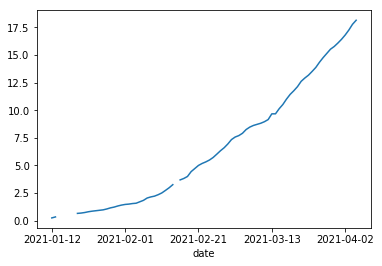

In [104]:
mu.get_pct_fully_vaccinated().plot()

In [57]:
vaccine = mu.get_pct_fully_vaccinated()

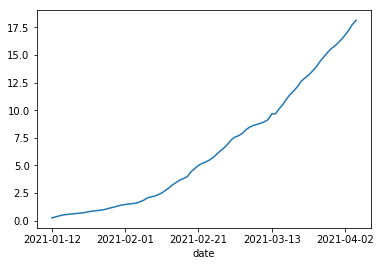

In [60]:
vaccine.interpolate().plot()

In [63]:
vaccine.index = pd.to_datetime(vaccine.index)

In [79]:
forecast_horizon = 60
df = pd.DataFrame(
    data=vaccine,
    index=pd.date_range(
        start=vaccine.index[0],
        periods=len(vaccine.index) + forecast_horizon,
        freq=vaccine.index.freq
    )
)

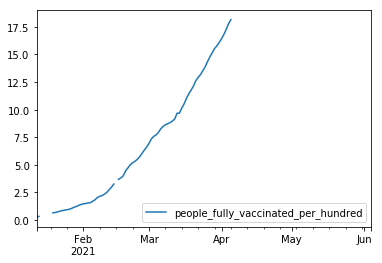

In [80]:
df.plot()

In [74]:
# Temporarily remove dates and make index numeric
di = df.index
df = df.reset_index().drop('index', 1)

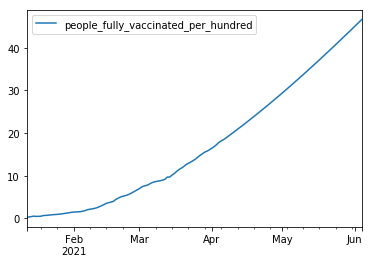

In [89]:
df.interpolate(method='spline', order=3).plot()

In [142]:
daily, cumm, _ = mu.get_metrics_by_state_US(state='Montana', policy_change_dates=mu.get_policy_change_dates_by_state_US('New York'))

/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:312: RuntimeWarning: divide by zero encountered in log
  #daily_local_death_new = daily_local_death_new.shift(1)
/home/quoc/bitbucket/covid-19/prognosis/model_utils.py:312: RuntimeWarning: divide by zero encountered in log
  #daily_local_death_new = daily_local_death_new.shift(1)


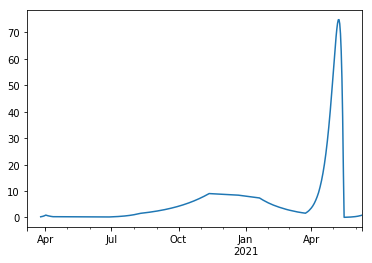

In [143]:
daily.predicted_death.plot()

In [141]:
mu.get_projected_pct_fully_vaccinated(scope='US', local='Montana').head(160).tail(60)

2021-04-13    24.792948
2021-04-14    25.206660
2021-04-15    25.620891
2021-04-16    26.035555
2021-04-17    26.450563
2021-04-18    26.865828
2021-04-19    27.281263
2021-04-20    27.696781
2021-04-21    28.112293
2021-04-22    28.527712
2021-04-23    28.942951
2021-04-24    29.357923
2021-04-25    29.772539
2021-04-26    30.186713
2021-04-27    30.600357
2021-04-28    31.013383
2021-04-29    31.425704
2021-04-30    31.837233
2021-05-01    32.247881
2021-05-02    32.657562
2021-05-03    33.066188
2021-05-04    33.473672
2021-05-05    33.879926
2021-05-06    34.284862
2021-05-07    34.688393
2021-05-08    35.090433
2021-05-09    35.490892
2021-05-10    35.889684
2021-05-11    36.286721
2021-05-12    36.681916
2021-05-13    37.075181
2021-05-14    37.466429
2021-05-15    37.855572
2021-05-16    38.242523
2021-05-17    38.627195
2021-05-18    39.009499
2021-05-19    39.389348
2021-05-20    39.766656
2021-05-21    40.141334
2021-05-22    40.513295
2021-05-23    40.882452
2021-05-24    41